In [1]:
'''
Title: Identfying Remote Sensing Indicators of & Classifying Gypsy Moth Defoliation
Date: July 13, 2020

Description: This script was developed alongside my Intermediate Quantiative Method course project.
The purpose of this project was to identify the most appropriate remote sensing indicators of Gypsy Moth defoliation and
compare two populer methods of binary classification, Logisitic Regression and Discriminant Analysis. The study area
for this study is an area of Gypsy Moth defoliation in New England (RI, CT, and Southern MA) from 2016. 
This project used the Landsat8 imagery (Bands1-7) and two raster layers provided by a doctoral student at Clark University. The first layer is a NLCD
landcover map of the study area. The second layer is a binary classification of defoliation derived from the S-CCD algorithm.

In this script, first I geoprocess the raster layers and prepare them for analysis. Then, I used TOC curves and Partial
Component Analysis to assess which remote sensing indicators were best for identifying defoliation. Finally, using Su's
binary classification as a "truth", I assessed whether Logistic Regression or Discriminant Analysis was better at
differentiatingbetween the two classes.

Note: This script uses R and Pythn simultaneously. This was done to access the TOC package available in R, but is not
available in Python.

''' 


#Import relevent libraries
import numpy as np
#Panda is a library for creating datframes
import pandas as pd
#SciKit learn is a library for scientific methods and tools
import sklearn
#matlpotlib is a library for data visualization
import matplotlib.pyplot as plt
#Seaborn is a library linked to matplotlib which makes nice graphics
import seaborn as sns
#Fiona is a library used to open and read geospatial files
from fiona.crs import from_epsg
#Geopandas is a library for making geographically referenced dataframe
import geopandas as gpd
#OS allows you to set a working folder. 
import os
#PyCrs is a library for converting between coordinate systems
import pycrs
#Rasterio is a library for processing geospatial data
import rasterio as rio
#Load R language into Python. I am doing this because I want to use a particular package
import rpy2.rinterface
#Set working folder here
dir = os.chdir("C:\\Users\\Emily\\Documents\\Summer_2020\\Py_DataScience_and_MachineLearning\\original\\Gypsy_Moth\\Landsat8Imagery")

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_BAG.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_BAG.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_GMT.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_GMT.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.

Can't load r

In [2]:
%load_ext RWinOut
#This ipython extension gets around display problems in the regular rpy2 extension

Loading extensions from ~\.ipython\extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.


C:\Users\Emily\anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Geoprocessing of Raster Layers

In [3]:
#Import TIF files - Landsat 8 and Gypsy Moth 
#Landsat 8 imagery for study area. The date of this imagery is July 13, 2016
tif1 = r"LC08_012031_20160713.tif"
#Hard classification of Gypsy Moth defoliation produced via SCCD 
tif2 = r"gm_esri_UTM.tif"
#Landcover types
tif3 = r"Mask_LC_UTM.tif"

In [4]:
#Use rasterio to open tif files and set them to a variable. NOw one can maniplulate the data
raster1 = rio.open(tif1)
SY_Data = rio.open(tif2)
raster2 = rio.open(tif3)

In [5]:
#Print metadata for each file to make sure images are functioning correctly. 
#This also reveals each layers size, projection, etc.
print(SY_Data.meta)
print(raster1.meta)
print(raster2.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 3.0, 'width': 13984, 'height': 13788, 'count': 1, 'crs': CRS.from_epsg(32619), 'transform': Affine(30.0, 0.0, 95114.93530782993,
       0.0, -30.0, 4826736.719272707)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 7737, 'height': 7963, 'count': 8, 'crs': CRS.from_epsg(32619), 'transform': Affine(30.0, 0.0, 191025.0,
       0.0, -30.0, 4744785.0)}
{'driver': 'GTiff', 'dtype': 'int8', 'nodata': -128.0, 'width': 6260, 'height': 6170, 'count': 1, 'crs': CRS.from_epsg(32619), 'transform': Affine(30.0, 0.0, 206220.29643941775,
       0.0, -30.0, 4712812.590616057)}


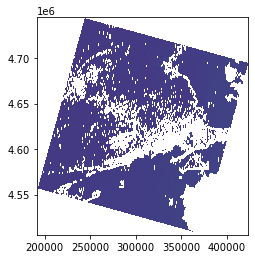

In [6]:
#Display raster data. This is also a test to see if that data is functioning correctly and allows to compare how each layer overlaps.
from rasterio.plot import show
#Show Landsat 8 tif. This shows the composit image, but one can also look at each band. 
show(raster1)

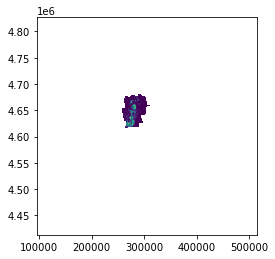

In [7]:
#Show hard classification
#Purpler = 0 (Foliated), Yellow = 1 (Defoliated). There are also some missing values here marked as "3".
show(SY_Data)

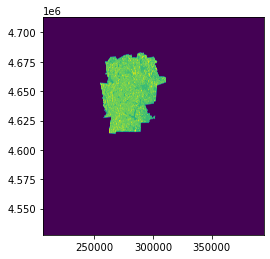

In [8]:
#Show landuse data
#There are about 15 different landuse classes in this map. Eventually, I want to isolated 41 (Deciduous Forest) and 
#43 (Mixed Forest), so limit spectral outliers.
show(raster2)

In [ ]:
#Here, I am reprojecting the TIF file to match the projection of the hard classification data. This code can be found 
#on the rasterio documentation.
#All of my files ave an original projection of the Landsat 8 imagery is EPSG3261 (UTM 19N). I am changing it to EPSG6350 
#(AlbersUS 1983). I did this because we're in a very small area and I want to ability to calculate area if necessary.

#Set variable with desired projection
dst_crs = 'EPSG:5070'

#This function changes the image metadata, reprojects & resamples each band of the image, and saves it as a new file.
#I turned this projection into a function so it can be used repeatedly. It takes four arguments - the input image name, the output
#image name, the new projection, and resample type.
def reproject(in_img, out_img, dst_crs, resample_type):
    import numpy as np
    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling

    #The first section updates the image metadata
    #First, it opens the original image
    with rasterio.open(in_img) as src:
        #Then, it stores the transform, width, and height for the new image. This determined using the "calculate
        #_default_transform function". It calculates the transofrmation between the original projection and the new one
        #while maintaining the original image dimensions.
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        #Here, I used the variables above to update the metadata. Very important!
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        #The second section outputs the new reprojected and resampled image
        #First, I identify the new file and allow python to write to the file
        with rasterio.open(out_img, 'w', **kwargs) as dst:
            #Now, I iterate through every band of each image reprojecting and resampling
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=resample_type)

In [ ]:
#Reproject the landuse map using Nearest Neighbor resampling
reproject("Mask_LC_UTM.tif", "Mask_LC_UTM_Albers83.tif", 'EPSG:5070', Resampling.nearest)

In [ ]:
#Reproject the Gypsy Moth defoliation map using Nearest Neighbor resampling
reproject("gm_esri_UTM.tif", "gm_esri_UTM_Albers83.tif", 'EPSG:5070', Resampling.nearest)

In [ ]:
#Reproject the Landsat8 Bands using Bilinear resampling
reproject("LC08_012031_20160713.tif", "LC08_012031_20160713_Reproj.tif", 'EPSG:5070', Resampling.bilinear)

In [9]:
#Now I will mask all of image files to a specific polygon vector. 

#Import the polygon creation function
from shapely.geometry import Polygon
#Create a polygon and set the coordinate points. 
poly = Polygon([(1990000, 2331000), (1991000, 2353000), (1984000, 2353000), (1973000, 2352000), (1975000, 2328000), (1990000, 2331000)])
#I tested that this function worked by calculating the area
poly.area

384000000.0

In [10]:
from shapely.geometry import box

GMbb = box(1991000, 2328000, 1973000, 2353000)

In [11]:
#Here I create a geodataframe using GeoPandas to contain my polygon feature. This line inserts the polygon I created
#into a dataframe and assigns the projection.
geo = gpd.GeoDataFrame({'geometry': GMbb}, index=[0], crs=from_epsg(5070))
#I assigned the geometry column to the "geom" named column. Prior to this, json was having trouble identifying geomtries
#in my geopandas dataframe. Not sure if it's completely necessary now because I reinstalled the package since. 
#geo = geo.rename(columns={'geometry': 'geom'}).set_geometry('geom')
#Print dataframe
print (geo)

                                            geometry
0  POLYGON ((1973000.000 2328000.000, 1973000.000...


C:\Users\Emily\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
#Checking that my geopandas dataframe is valid
from rasterio.features import is_valid_geom
is_valid_geom(geo.iloc[0]['geometry'])

#This funciton parses the geodataframe into a format which can be used for rasterio
def getFeatures(gdf):
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

#Here, I set the parsed coordinates to a variables and print them
coords = getFeatures(geo)
print(coords[0])

{'type': 'Polygon', 'coordinates': [[[1973000.0, 2328000.0], [1973000.0, 2353000.0], [1991000.0, 2353000.0], [1991000.0, 2328000.0], [1973000.0, 2328000.0]]]}


In [13]:
#A function to mask each image
def mask_img(in_img, out_img, shape):
    #open the source image
    with rio.open(in_img) as src:
        from rasterio.mask import mask
        #crop the source image using the polygon shape and crop the image.
        out_image, out_transform = mask(src, shape, crop=True)
        #Originally, we will copy over the source metadata
        out_meta = src.meta
        #Update image size and transformation
        out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    #Write new image
    with rio.open(out_img, "w", **out_meta) as dest:
        dest.write(out_image)

In [14]:
#Mask Landcover Data
mask_img("Mask_LC_UTM_Albers83.tif", "LC_masked.tif", coords)


In [15]:
#Mask Gypsy Moth 2016 Data
mask_img("gm_esri_UTM_Albers83.tif", "GM_masked.tif", coords)

In [16]:
#Mask Satellite Imagery
mask_img("LC08_012031_20160713_Reproj.tif", "LC08_012031_20160713_Masked.tif", coords)

# Dataframe Preprocessing

In [15]:
#Open and flatten all clipped layers as numpy arrays so they can be organized into a Pandas dataframe
#Here I use the package OSGEO (an open-source library for geogrpahic data) to convert my TIF imagery to numpy arrays. 
#I had issues trying to do this with rasterio hence why I used this other library.
from osgeo import gdal
#Open the masked landuse image
ds = gdal.Open("LC_masked.tif")
#Specify the band you want and read is as an array
Clip_LC = np.array(ds.GetRasterBand(1).ReadAsArray())
#I printed the shape as a check point - I want to make sure all of my files definitely have the same geometry
print (Clip_LC.shape)
#Here I flatten the 2-D array to a 1-D array
Clip_LC = Clip_LC.flatten()
#Print length of the 1-D array, i.e. the # of observations of per column in the dataframe
print (len(Clip_LC))

#Repeat the process for the Defoliation layer
ds = gdal.Open("GM_masked.tif")
Clip_GM = np.array(ds.GetRasterBand(1).ReadAsArray())
print(Clip_GM.shape)
Clip_GM = Clip_GM.flatten()
print (len(Clip_GM))

#For the final TIF, we will repeat the process for each band of the Landsat8 image
#The process is the same, except I alter the band number
ds = gdal.Open("LC08_012031_20160713_Masked.tif")
Band1 = np.array(ds.GetRasterBand(1).ReadAsArray())
print (Band1.shape)
Band1 = Band1.flatten()
print (len(Band1))
Band2 = np.array(ds.GetRasterBand(2).ReadAsArray())
Band2 = Band2.flatten()
Band3 = np.array(ds.GetRasterBand(3).ReadAsArray())
Band3 = Band3.flatten()
Band4 = np.array(ds.GetRasterBand(4).ReadAsArray())
Band4 = Band4.flatten()
Band5 = np.array(ds.GetRasterBand(5).ReadAsArray())
Band5 = Band5.flatten()
Band6 = np.array(ds.GetRasterBand(6).ReadAsArray())
Band6 = Band6.flatten()
Band7 = np.array(ds.GetRasterBand(7).ReadAsArray())
Band7 = Band7.flatten()
Band8 = np.array(ds.GetRasterBand(8).ReadAsArray())
Band8 = Band8.flatten()
               

(835, 601)
501835
(835, 601)
501835
(835, 601)
501835


In [16]:
#Stack all data using Numpy. This allows each image to become a column in the dataframe
GM_Stack = np.column_stack([Clip_LC, Clip_GM, Band1, Band2, Band3, Band4, Band5, Band6, Band7, Band8])

In [17]:
#A Pandas dataframe was then created from with the vertically stacked 2D array, GM_Data, and assigned column names.
GM_Data = pd.DataFrame(GM_Stack, columns=['Landcover', 'GM_Presence', 'Band1', 'Band2', 'Band3', 'Band4', 'Band5', 'Band6', 'Band7', 'Band8'])
#Get a description of data - a check to make sure it looks okay
GM_Data.describe()

,Landcover,GM_Presence,Band1,Band2,Band3,Band4,Band5,Band6,Band7,Band8
count,501835.000000,501835.000000,467602.000000,467602.000000,467602.000000,467602.000000,467602.000000,467602.000000,467602.000000,467602.000000
mean,43.482059,0.299104,272.713989,314.498199,581.681824,451.958191,3160.610107,1994.963013,948.036438,320.695587
std,29.861376,0.569453,82.378769,95.102249,129.123108,194.881317,774.922363,505.798798,339.448669,21.262844
min,-128.000000,0.000000,-285.119171,-169.503998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,0.000000,233.140060,262.639893,523.743774,309.527588,2749.899902,1787.957153,726.968384,322.000000
50%,41.000000,0.000000,271.340759,301.150146,579.161133,409.704102,3179.970459,1981.015625,897.574036,322.000000
75%,43.000000,1.000000,310.143219,357.896484,636.399536,564.729248,3672.035156,2279.907227,1158.085449,322.000000
max,95.000000,3.000000,3261.919434,3742.094971,4171.775879,4495.917969,6328.212402,5355.331055,4868.395508,386.000000


In [18]:
#Here I Replace Null values with Zero
GM_Data.fillna(0, inplace=True)
#Sum all the null values in each column to make sure it worked
GM_Data.isnull().sum()

Landcover      0
GM_Presence    0
Band1          0
Band2          0
Band3          0
Band4          0
Band5          0
Band6          0
Band7          0
Band8          0
dtype: int64

In [19]:
#Check what unique landcover types there are
GM_Data.Landcover.unique()

array([  43.,   90.,   22.,   42.,   41.,   21.,   81.,   11.,   71.,
         31.,   23.,   95.,   52.,   24.,   82., -128.], dtype=float32)

In [20]:
# Replacing rows with 0 where Landcover is not 41 (Deciduous) and 43 (Mixed Forest)
GM_Data.loc[((GM_Data['Landcover'] != 43.0) & (GM_Data['Landcover'] != 41.0)), 'GM_Presence'] = 0
GM_Data.loc[((GM_Data['Landcover'] != 43.0) & (GM_Data['Landcover'] != 41.0)), 'Band1'] = 0
GM_Data.loc[((GM_Data['Landcover'] != 43.0) & (GM_Data['Landcover'] != 41.0)), 'Band2'] = 0
GM_Data.loc[((GM_Data['Landcover'] != 43.0) & (GM_Data['Landcover'] != 41.0)), 'Band3'] = 0
GM_Data.loc[((GM_Data['Landcover'] != 43.0) & (GM_Data['Landcover'] != 41.0)), 'Band4'] = 0
GM_Data.loc[((GM_Data['Landcover'] != 43.0) & (GM_Data['Landcover'] != 41.0)), 'Band5'] = 0
GM_Data.loc[((GM_Data['Landcover'] != 43.0) & (GM_Data['Landcover'] != 41.0)), 'Band6'] = 0
GM_Data.loc[((GM_Data['Landcover'] != 43.0) & (GM_Data['Landcover'] != 41.0)), 'Band7'] = 0
GM_Data.loc[((GM_Data['Landcover'] != 43.0) & (GM_Data['Landcover'] != 41.0)), 'Band8'] = 0

# Replace rows with 0 where Cloudcover = 0
GM_Data.loc[(GM_Data['Band8'] == 0.0), 'Band1'] = 0
GM_Data.loc[(GM_Data['Band8'] == 0.0), 'Band2'] = 0             
GM_Data.loc[(GM_Data['Band8'] == 0.0), 'Band3'] = 0
GM_Data.loc[(GM_Data['Band8'] == 0.0), 'Band4'] = 0
GM_Data.loc[(GM_Data['Band8'] == 0.0), 'Band5'] = 0
GM_Data.loc[(GM_Data['Band8'] == 0.0), 'Band6'] = 0
GM_Data.loc[(GM_Data['Band8'] == 0.0), 'Band7'] = 0

#This is the final form of my original dataframe - GM_Data

In [21]:
#Drop rows which are not target landuses, where the GM layer hase no data, or if the rows are covered in clouds
indexNames = GM_Data[(GM_Data['Landcover'] != 41) & (GM_Data['Landcover'] != 43) | (GM_Data['GM_Presence'] == 3) | (GM_Data['Band8'] == 0)].index
#Make a new dataframe with only the select rows. However, this will maintain the original index
GM_Select = GM_Data.drop(indexNames)

In [22]:
#Using the limited dataframe, I created new columns and calculated RS Indices
GM_Select['NDVI'] = (GM_Select['Band5'] - GM_Select['Band4'])/(GM_Select['Band5'] + GM_Select['Band4'])
GM_Select['SAVI'] = (GM_Select['Band4'] - GM_Select['Band3'])/((GM_Select['Band4'] + GM_Select['Band3'] + 0.5) * 1.5)
GM_Select['MSAVI'] = (2 * GM_Select['Band4'] + 1 - np.sqrt((2 * GM_Select['Band4'] + 1)**2 - 8*(GM_Select['Band4'] - GM_Select['Band3']))/2)
GM_Select['NDMI'] = (GM_Select['Band5'] - GM_Select['Band6'])/(GM_Select['Band5'] + GM_Select['Band6'])
GM_Select['TCBright'] = (0.3029*GM_Select['Band2'] + .2786*GM_Select['Band3'] + .4733*GM_Select['Band4'] + .5599*GM_Select['Band5'] + .508*GM_Select['Band6'] + .1872*GM_Select['Band7'])
GM_Select['TCGreen'] = (-.2941*GM_Select['Band2'] + -.243*GM_Select['Band3'] + -.5424*GM_Select['Band4'] + .7276*GM_Select['Band5'] + .0713*GM_Select['Band6'] + -.1608*GM_Select['Band7'])
GM_Select['TCWet'] = (0.1511*GM_Select['Band2'] + .1973*GM_Select['Band3'] + .3283*GM_Select['Band4'] + .3407*GM_Select['Band5'] + -.7117*GM_Select['Band6'] + -.4559*GM_Select['Band7'])
#Print to make sure it looks corect
print (GM_Select)
#I exported the limited dataframe to a a CSV in order to open it in the R cells more easliy. I was having trouble transferring the Python dataframe directly to R.
GM_Select.to_csv("C:\\Users\\Emily\\Documents\\Summer_2020\\Py_DataScience_and_MachineLearning\\original\\Gypsy_Moth\\Landsat8Imagery\\GM_Select.csv")

        Landcover  GM_Presence       Band1       Band2        Band3  \
602          43.0          0.0  303.164825  415.967316   789.300415   
603          43.0          0.0  338.623688  449.160767   738.687439   
604          43.0          0.0  299.536682  416.954041   733.375916   
605          41.0          0.0  332.190002  444.117798   854.510742   
606          41.0          0.0  523.816040  634.345642  1083.464844   
...           ...          ...         ...         ...          ...   
501084       43.0          0.0  176.760757  223.303848   522.896484   
501085       43.0          0.0  185.020050  227.481110   514.465515   
501086       41.0          0.0  193.221130  230.548569   507.148224   
501087       43.0          0.0  198.774643  231.799988   515.386780   
501088       43.0          0.0  208.610306  234.628723   504.191711   

             Band4        Band5        Band6        Band7       Band8  \
602     596.334839  4376.997559  2080.958740  1023.578857  330.081268   
6

# Multiple TOC Curve

In [23]:
%%R
#The symbol %%R calls R Magic and designates that this cell will use R, not Python
#Here I am installing several packages that are dependencies for th TOC package, which is what I want to use
install.packages('utils', repos='http://cran.us.r-project.org', quiet=TRUE )
library(utils)
install.packages("Rcpp", repos='http://cran.us.r-project.org', quiet=TRUE)
library(Rcpp)
install.packages("sp", repos='http://cran.us.r-project.org', quiet=TRUE)
library(sp)
install.packages("bit", repos='http://cran.us.r-project.org', quiet=TRUE)
library(bit)
install.packages("rgdal", repos='http://cran.us.r-project.org', quiet=TRUE)
library(rgdal)
install.packages("raster", repos='http://cran.us.r-project.org', quiet=TRUE)
library(raster)
install.packages('TOC','C:/Users/Emily/anaconda3/lib/R/library/',type = 'source')
library(TOC)

package 'Rcpp' successfully unpacked and MD5 sums checked
package 'sp' successfully unpacked and MD5 sums checked
package 'bit' successfully unpacked and MD5 sums checked
package 'rgdal' successfully unpacked and MD5 sums checked
package 'raster' successfully unpacked and MD5 sums checked
--- Please select a CRAN mirror for use in this session ---


In [8]:
%%R
##Set the working directory to appropriate folder
setwd("C:/Users/Emily/Documents/Summer_2020/Py_DataScience_and_MachineLearning/original/Gypsy_Moth/Landsat8Imagery/")
##Open the CV+SV saved from the earlier portion of this code.
GM_Select_r <- read.csv(file ="GM_Select.csv", header=TRUE, dec=".", stringsAsFactors=FALSE)

In [11]:
%%R
##Create new numeric variables from dataframe columns. TOC requires this format in order to run. It will not intake columns as is.
indexB1 <- (GM_Select_r$Band1)
indexB2 <- (GM_Select_r$Band2)
indexB3 <- (GM_Select_r$Band3)
indexB4 <- (GM_Select_r$Band4)
indexB5 <- (GM_Select_r$Band5)
indexB6 <- (GM_Select_r$Band6)
indexB7 <- (GM_Select_r$Band7)
indexNDVI <- (GM_Select_r$NDVI)
indexSAVI <- (GM_Select_r$SAVI)
indexMSAVI <- (GM_Select_r$MSAVI)
indexNDMI <- (GM_Select_r$NDMI)
indexTCB <- (GM_Select_r$TCBright)
indexTCG <- (GM_Select_r$TCGreen)
indexTCW <- (GM_Select_r$TCWet)

##Create reference boolean image for input into TOC
boolean <- (GM_Select_r$GM_Presence)

In [12]:
%%R
##Create TOC objects. These lines creates 100 equal intervals for each index variable. 
##For these TOC objects, only the Indices change.Ther is one TOC object per index variable.
tocdB1 <- TOC(indexB1, boolean, nthres=100, thres=NULL, P=NA, Q=NA,
              progress=FALSE, units=character(0))
tocdB2 <- TOC(indexB2, boolean, mask, nthres=100, thres=NULL, P=NA, Q=NA,
              progress=FALSE, units=character(0))
tocdB3 <- TOC(indexB3, boolean, mask, nthres=100, thres=NULL, P=NA, Q=NA,
              progress=FALSE, units=character(0))
tocdB4 <- TOC(indexB4, boolean, mask, nthres=100, thres=NULL, P=NA, Q=NA,
              progress=FALSE, units=character(0))
tocdB5 <- TOC(indexB5, boolean, mask, nthres=100, thres=NULL, P=NA, Q=NA,
              progress=FALSE, units=character(0))
tocdB6 <- TOC(indexB6, boolean, mask, nthres=100, thres=NULL, P=NA, Q=NA,
              progress=FALSE, units=character(0))
tocdB7 <- TOC(indexB7, boolean, mask, nthres=100, thres=NULL, P=NA, Q=NA,
              progress=FALSE, units=character(0))
tocdNDVI <- TOC(indexNDVI, boolean, mask, nthres=100, thres=NULL, P=NA, Q=NA,
                progress=FALSE, units=character(0))
tocdSAVI <- TOC(indexSAVI, boolean, mask, nthres=100, thres=NULL, P=NA, Q=NA,
                progress=FALSE, units=character(0))
tocdMSAVI <- TOC(indexMSAVI, boolean, mask, nthres=100, thres=NULL, P=NA, Q=NA,
                 progress=FALSE, units=character(0))
tocdNDMI <- TOC(indexNDMI, boolean, mask, nthres=100, thres=NULL, P=NA, Q=NA,
                progress=FALSE, units=character(0))
tocdTCB <- TOC(indexTCB, boolean, mask, nthres=100, thres=NULL, P=NA, Q=NA,
               progress=FALSE, units=character(0))
tocdTCG <- TOC(indexTCG, boolean, mask, nthres=100, thres=NULL, P=NA, Q=NA,
               progress=FALSE, units=character(0))
tocdTCW <- TOC(indexTCW, boolean, mask, nthres=100, thres=NULL, P=NA, Q=NA,
               progress=FALSE, units=character(0))

In [13]:
%%R
#In this cell, I am creating the multiple TOC Curve image
#Here, I am designating a JPG file to export TOC plot
png(file = "GM_Multi_TOC_Code.jpg", width = 550, height = 480)

#Set the image plot to a square
par(pty="s")
#Create plot object and axes
graphics::plot(1, type="l", main = "TOC Curve", lty="dashed",xlab= "Hits+False Alarms (Pixels)", ylab="Hits (Pixels)",lwd=2, col=rgb(128,100,162, maxColorValue=255), xlim=c(0, 314346),ylim=c(0, 101575), bty='L')

#Plotting multiple lines to create multi-TOC plot
#minimum line
lines(c(0, 101575), c(0,101575), 
      lty="dotdash", lwd=2, col=rgb(50, 50,50, maxColorValue=255)) 
#maximum line
lines(c(212771, 314346), c(0,101575), 
      lty="dotdash", lwd=2, col=rgb(50,50,50, maxColorValue=255)) 

#hits+misses line
lines(c(0, 314346), c(101575, 101575), lwd=3, col=rgb(150,150,150, maxColorValue=255))

#uniform line
lines(c(0, 314346), c(0, 101575), lty="dotted", lwd=2, col=rgb(25,25,25, maxColorValue=255))

#TOC object lines
#Band1
lines(tocdB1@table$"Hits+FalseAlarms", tocdB1@table$Hits, lwd=2, col=rgb(255,0,255, maxColorValue=255))
#Band2
lines(tocdB2@table$"Hits+FalseAlarms", tocdB2@table$Hits, lwd=2, col=rgb(0,0,255, maxColorValue=255))
#Band3
lines(tocdB3@table$"Hits+FalseAlarms", tocdB3@table$Hits, lwd=2, col=rgb(0,255,0, maxColorValue=255))
#Band4
lines(tocdB4@table$"Hits+FalseAlarms", tocdB4@table$Hits, lwd=2, col=rgb(255,0,0, maxColorValue=255))
#Band5
lines(tocdB5@table$"Hits+FalseAlarms", tocdB5@table$Hits, lwd=2, col=rgb(255,150,50, maxColorValue=255))
#Band6
lines(tocdB6@table$"Hits+FalseAlarms", tocdB6@table$Hits, lwd=2, col=rgb(150,150,150, maxColorValue=255))
#Band7
lines(tocdB7@table$"Hits+FalseAlarms", tocdB7@table$Hits, lwd=2, col=rgb(100,100,100, maxColorValue=255))
#NDVI
lines(tocdNDVI@table$"Hits+FalseAlarms", tocdNDVI@table$Hits, lty="dotted", lwd=2, col=rgb(255,100,255, maxColorValue=255))
#SAVI
lines(tocdSAVI@table$"Hits+FalseAlarms", tocdSAVI@table$Hits, lty="dotted", lwd=2, col=rgb(0,0,255, maxColorValue=255))
#MSAVI
lines(tocdMSAVI@table$"Hits+FalseAlarms", tocdMSAVI@table$Hits, lty="dotted", lwd=2, col=rgb(100,250,0, maxColorValue=255))
#NDMI
lines(tocdNDMI@table$"Hits+FalseAlarms", tocdNDMI@table$Hits, lty="dotted", lwd=2, col=rgb(200,0,0, maxColorValue=255))
#TasseledCap Brightness
lines(tocdTCB@table$"Hits+FalseAlarms", tocdTCB@table$Hits, lty="dotted", lwd=2, col=rgb(255,150,50, maxColorValue=255))
#TasseledCap Greeness
lines(tocdTCG@table$"Hits+FalseAlarms", tocdTCG@table$Hits, lty="dotted", lwd=2, col=rgb(10,150,0, maxColorValue=255))
#TasseledCap Wetness
lines(tocdTCW@table$"Hits+FalseAlarms", tocdTCW@table$Hits, lty="dotted", lwd=2, col=rgb(100,100,100, maxColorValue=255))

#Set area outside plot for legend
par(xpd=NA)
#Set legend. Must define names, line color, and line patterns. 
legend("topright", inset=c(-0.25, 0.2), c("Hits+Misses", "Minimum", "Maximum", "Uniform", "Band1", "Band2", "Band3", "Band4", "Band5", "Band6", "Band7", "NDVI", "SAVI", "MSAVI", "NDMI", "TCBrightness", "TCGreeness", "TCWetness"), 
       col = c(rgb(150,150,150, maxColorValue=255), rgb(50, 50,50, maxColorValue=255), rgb(50,50,50, maxColorValue=255), rgb(25,25,25, maxColorValue=255), rgb(255,0,255, maxColorValue=255), rgb(0,0,255, maxColorValue=255), rgb(0,255,0, maxColorValue=255), rgb(255,0,0, maxColorValue=255),rgb(255,150,50, maxColorValue=255), rgb(150,150,150, maxColorValue=255), rgb(100,100,100, maxColorValue=255), rgb(255, 100, 255, maxColorValue=255), rgb(0,0,255, maxColorValue=255), rgb(100,250,0, maxColorValue=255), rgb(200,0,0, maxColorValue=255), rgb(255,150,50, maxColorValue=255), rgb(10,150,0, maxColorValue=255), rgb(100,100,100, maxColorValue=255)),
       lty = c(1, 4, 4, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3), merge = TRUE, bty="n", lwd=c(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

#End image development. This will output the image.
dev.off()


png 
  2 


In [15]:
%%R
#Saving AUC values. I will use these to rank the bands by AUC value
#For the first part, I am setting the AUC values to variables
aucB1 <- tocdB1@AUC
aucB2 <- tocdB2@AUC
aucB3 <- tocdB3@AUC
aucB4 <- tocdB4@AUC
aucB5 <- tocdB5@AUC
aucB6 <- tocdB6@AUC
aucB7 <- tocdB7@AUC
aucNDVI <- tocdNDVI@AUC
aucSAVI <- tocdSAVI@AUC
aucMSAVI <- tocdMSAVI@AUC
aucNDMI <- tocdNDMI@AUC
aucTCB <- tocdTCB@AUC
aucTCG <- tocdTCG@AUC
aucTCW <- tocdTCW@AUC
#Here, I am concerned with curviture rather than the raw AUC. 
#Therefore, I subtracted the AUC from 1 for those below the "uniform" line.
opB5 <- 1.0-aucB5
opNDMI <- 1.0-aucNDMI
opNDVI <- 1.0-aucNDVI
opTCB <- 1.0-aucTCB
opTCG <- 1.0-aucTCG
opTCW <- 1.0-aucTCW


In [16]:
%%R
#Creating a dataframe for the input variables and their AUC values so I can rank the AUC values
TOC_df <- data.frame("AUC" = c(aucB1, aucB2, aucB3, aucB4, opB5, aucB6, aucB7, opNDVI, aucSAVI, aucMSAVI, opNDMI, opTCB, opTCG, opTCW), "Name" = c("Band1","Band2", "Band3", "Band4", "Band5", "Band6", "Band7", "NDVI", "SAVI", "MSAVI", "NDMI", "TCB", "TCG", "TCW")) 

#Create a new column
TOC_df$rank <- NA
#Order the AUC values
order.AUC <- order(TOC_df$AUC)
#Create a new dataframe which is order by AUC
TOC_df1 <- TOC_df[order.AUC,]
#create a new column called "rank"
TOC_df1$rank <- rank(TOC_df1$AUC)
#Display that new dataframe
TOC_df1

         AUC  Name rank
12 0.5267322   TCB    1
1  0.7115342 Band1    2
3  0.7203319 Band3    3
2  0.7824171 Band2    4
6  0.8188207 Band6    5
7  0.8415697 Band7    6
4  0.8430859 Band4    7
10 0.8431458 MSAVI    8
5  0.8584792 Band5    9
9  0.8650129  SAVI   10
13 0.8701392   TCG   11
8  0.8704007  NDVI   12
14 0.8782514   TCW   13
11 0.8879669  NDMI   14


In [24]:
#Now I am back to using Python
#I am calling the GM_Select dataframe from before which contain select rows. 
#Remove non-variable bands - Gypsy Moth Presence, Landcover Type, Cloudmask, and Study Area Mask. This will be the independent variables for the classification methods.
Bands_only = GM_Select.drop(['GM_Presence', 'Landcover', 'Band8'], axis=1)
#Checking to make sure it worked
Bands_only.describe()

,Band1,Band2,Band3,Band4,Band5,Band6,Band7,NDVI,SAVI,MSAVI,NDMI,TCBright,TCGreen,TCWet
count,314346.000000,314346.000000,314346.000000,314346.000000,314346.000000,314346.000000,314346.000000,314346.000000,314346.000000,314346.000000,314346.000000,314346.000000,314346.000000,314346.000000
mean,280.726410,321.454926,593.226074,469.221313,3234.654297,2106.506592,995.356384,0.736361,-0.093409,469.350342,0.205840,3552.242432,1850.475342,-531.276611
std,66.292358,75.620300,87.154030,170.050888,610.123962,365.546204,277.775085,0.111237,0.080756,170.347382,0.141449,358.256836,543.599792,438.952850
min,-233.728867,-127.737000,158.667175,64.269463,390.712036,201.141235,86.119255,0.105750,-0.322104,63.328056,-0.261016,507.233978,-420.678284,-2678.927734
25%,247.086315,273.112946,540.393188,330.209801,2767.470581,1859.687225,770.226395,0.652025,-0.164763,330.051697,0.090501,3379.702148,1404.150116,-871.277496
50%,278.258163,310.741272,589.452728,435.782166,3188.582031,2046.850098,947.701019,0.757486,-0.101806,435.939850,0.223054,3570.254272,1825.220581,-474.923035
75%,313.988625,362.532845,637.861755,583.530350,3685.317383,2340.462524,1192.352600,0.832795,-0.029315,583.953888,0.328340,3746.509521,2275.661682,-159.591606
max,2436.635498,2740.566162,3286.294922,3575.005371,6195.914062,4451.320801,3543.995850,0.932338,0.112449,3575.585938,0.625845,8377.022461,4112.142090,494.586548


# Partial Component Analysis

In [25]:
#Standardizing independent variables for PCA
import sklearn
#Import scaler tool
from sklearn.preprocessing import StandardScaler
#Set the scaler object
scaler = StandardScaler()
#Standardize the bands
scaler.fit(Bands_only)
#Set transformed bands to a new variable
scaled_data = scaler.transform(Bands_only)

In [26]:
#Now, I run PCA with the standardized indepenent variables
from sklearn.decomposition import PCA
#Here I designate that I want the first 5 components from PCA
pca = PCA(n_components = 5)
#I used the scaled data to fit PCA
pca.fit(scaled_data)
#Set outputs to new variable
x_pca = pca.transform(scaled_data)
x_pca.shape

(314346, 5)

In [27]:
#Display PCA components - correlation for each variable
pca.components_

array([[ 0.22313751,  0.26931015,  0.23981771,  0.30528194, -0.2111348 ,
         0.27773997,  0.3017817 , -0.2973692 ,  0.29224783,  0.30530602,
        -0.293027  ,  0.08849809, -0.25606152, -0.29642785],
       [ 0.32253554,  0.23532435,  0.30124268,  0.03846264,  0.4397921 ,
         0.1787298 ,  0.06256837,  0.1506214 , -0.15911174,  0.03807093,
         0.16345836,  0.5651815 ,  0.33469066,  0.10710448],
       [ 0.48519912,  0.40689954,  0.27051342,  0.03674737, -0.15901007,
        -0.422971  , -0.22277534, -0.0114612 , -0.12845857,  0.03651247,
         0.17882855, -0.35059175, -0.16525048,  0.26552007],
       [-0.5953447 , -0.13572642,  0.6662162 ,  0.2221225 ,  0.01109898,
        -0.17042714,  0.01229681, -0.02076272, -0.02788482,  0.22183552,
         0.16477858,  0.01040674, -0.05820919,  0.15353313],
       [-0.08451307,  0.10614251, -0.43799004,  0.31620255,  0.22729908,
        -0.26578337, -0.06828974, -0.3081586 ,  0.44396788,  0.31615403,
         0.20395228,  0.11

In [28]:
#Here I calculate the percent explained variance from the eigenvalues becuase it's easier to interpret. 
#I divided each eigen value by the sum of all the eigenvalues.
C1 = pca.explained_variance_[0]/13.9446753*100
C2 = pca.explained_variance_[1]/13.9446753*100
C3 = pca.explained_variance_[2]/13.9446753*100
C4 = pca.explained_variance_[3]/13.9446753*100
C5 = pca.explained_variance_[4]/13.9446753*100

In [29]:
#See percent variance explained for each component
#I make a datframe of each compoent, it's eigenvalue, anfd it's percent explained. Here I set the data
data ={'Component #':['1', '2', '3', '4', '5'], 
       'Eigenvalue':[format(pca.explained_variance_[0], '.2f'), format(pca.explained_variance_[1], '.2f'), format(pca.explained_variance_[2], '.2f'), format(pca.explained_variance_[3], '.2f'), format(pca.explained_variance_[4], '.2f')],
       'Percent Variance':[format(C1, '.2f'), format(C2, '.2f'), format(C3, '.2f'), format(C4, '.2f'), format(C5, '.2f')]}
#Then I bring the data into a dataframe and provide column names
PCA_data = pd.DataFrame(data, columns = ['Component #', 'Eigenvalue', 'Percent Variance'])
print(PCA_data)

  Component # Eigenvalue Percent Variance
0           1      10.42            74.74
1           2       2.67            19.13
2           3       0.53             3.78
3           4       0.22             1.56
4           5       0.11             0.78


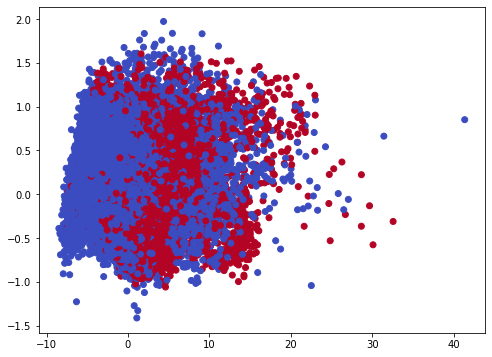

In [33]:
#Visualize PCA components
#This cell allows me to call graph the components againts each other. This was more for my own visualization purposes.
import matplotlib.pyplot as plt
import seaborn as sns
#Set figure size
plt.figure(figsize = (8,6))
#Here I graph component 1 vs Component 5
plt.scatter(x_pca[:,0], x_pca[:,4], c=GM_Select['GM_Presence'], cmap='coolwarm')

In [34]:
#Make a heat map of components
#First I make dataframe of components
PCA_comp = pd.DataFrame(pca.components_)
#Then set column names
PCA_comp.columns = ['Band1', 'Band2', 'Band3', 'Band4', 'Band5', 'Band6', 'Band7', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'TCBright','TCGreen','TCWet']
#Display dataframe
PCA_comp

,Band1,Band2,Band3,Band4,Band5,Band6,Band7,NDVI,SAVI,MSAVI,NDMI,TCBright,TCGreen,TCWet
0,0.223138,0.269310,0.239818,0.305282,-0.211135,0.277740,0.301782,-0.297369,0.292248,0.305306,-0.293027,0.088498,-0.256062,-0.296428
1,0.322536,0.235324,0.301243,0.038463,0.439792,0.178730,0.062568,0.150621,-0.159112,0.038071,0.163458,0.565181,0.334691,0.107104
2,0.485199,0.406900,0.270513,0.036747,-0.159010,-0.422971,-0.222775,-0.011461,-0.128459,0.036512,0.178829,-0.350592,-0.165250,0.265520
3,-0.595345,-0.135726,0.666216,0.222123,0.011099,-0.170427,0.012297,-0.020763,-0.027885,0.221836,0.164779,0.010407,-0.058209,0.153533
4,-0.084513,0.106143,-0.437990,0.316203,0.227299,-0.265783,-0.068290,-0.308159,0.443968,0.316154,0.203952,0.117197,0.137559,0.310687


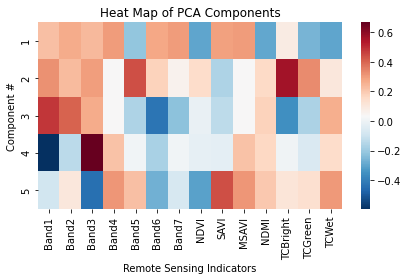

In [35]:
#Now, I will convert the dataframe of correlations to a heatmap
#Create plot object
plt1 = plt.axes()
#Create a heatmap from the component dataframe
sns.heatmap(PCA_comp, cmap="RdBu_r")
#Set titles and labels
plt1.set_title('Heat Map of PCA Components')
plt1.set_ylabel('Component #')
plt1.set_xlabel('Remote Sensing Indicators')
plt1.set_yticklabels(['1','2','3','4','5'])
#Ensure the labels don't get cutoff
plt.tight_layout()
#Save the figure s a jpeg
plt.savefig('PCA_Heat.jpeg')

# Logistic Regression

### 1. Logistic Model with All Independent Variables

In [37]:
#Set x & y variables for Logistic Regression
#The first set of x-variables includes all of the independent variables
x = GM_Select.drop(['GM_Presence', 'Landcover', 'Band8'], axis=1)
#The second set ot x-variables includes the select 4-variables (NDVI, NDMI, TCGreen, & TCWet)
x2 = GM_Select.drop(['GM_Presence', 'Landcover', 'Band8', 'Band1', 'Band2', 'Band3', 'Band4', 'Band5', 'Band6', 'Band7', 'SAVI', 'MSAVI', 'TCBright'], axis=1)
#Set dependent variable to Gypsy Moth presence
y = GM_Select['GM_Presence']

In [38]:
#Split data for training and testin
from sklearn.model_selection import train_test_split
#Here we split the data - using all the independent variables. 70% of the data is used for training, 30% for training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

#Here I create the first logistic regression model
from sklearn.linear_model import LogisticRegression
logModel = LogisticRegression()
#Fit the model with the training data
fit_modelLR = logModel.fit(x_train, y_train)

#Connect predictions back to dataframe
#Here, I create a dataframe of the logisitic model predictions. I set the column index to that from the GM_Select.
#This index will connect back to to large dataframe as well. 
df = pd.DataFrame(logModel.predict(x_test), columns=['LR_All_Pred'], index = x_test.index.copy())
#I merge the predictions to the GM_Select dataframe
df_out = pd.merge(GM_Select, df, how = 'left', left_index = True, right_index = True)
#I fill null values in the prediction column to 2 - these are training data
df_out.fillna(value=2, inplace=True)
print (df_out)

        Landcover  GM_Presence       Band1       Band2        Band3  \
602          43.0          0.0  303.164825  415.967316   789.300415   
603          43.0          0.0  338.623688  449.160767   738.687439   
604          43.0          0.0  299.536682  416.954041   733.375916   
605          41.0          0.0  332.190002  444.117798   854.510742   
606          41.0          0.0  523.816040  634.345642  1083.464844   
...           ...          ...         ...         ...          ...   
501084       43.0          0.0  176.760757  223.303848   522.896484   
501085       43.0          0.0  185.020050  227.481110   514.465515   
501086       41.0          0.0  193.221130  230.548569   507.148224   
501087       43.0          0.0  198.774643  231.799988   515.386780   
501088       43.0          0.0  208.610306  234.628723   504.191711   

             Band4        Band5        Band6        Band7       Band8  \
602     596.334839  4376.997559  2080.958740  1023.578857  330.081268   
6

In [40]:
#I get coefficents and intercept from LR model. This will be used for TOC Curves comparing the classification outcomes.

#Create a nw column with the calculations
df_out['LR_All'] = ((logModel.coef_[0][0]*df_out['Band1'])+
                     (logModel.coef_[0][1]*df_out['Band2'])+
                     (logModel.coef_[0][2]*df_out['Band3'])+
                     (logModel.coef_[0][3]*df_out['Band4'])+
                     (logModel.coef_[0][4]*df_out['Band5'])+
                     (logModel.coef_[0][5]*df_out['Band6'])+
                     (logModel.coef_[0][6]*df_out['Band7'])+
                     (logModel.coef_[0][7]*df_out['NDVI'])+
                     (logModel.coef_[0][8]*df_out['SAVI'])+
                     (logModel.coef_[0][9]*df_out['MSAVI'])+
                     (logModel.coef_[0][10]*df_out['NDMI'])+
                     (logModel.coef_[0][11]*df_out['TCBright'])+
                     (logModel.coef_[0][12]*df_out['TCGreen'])+
                     (logModel.coef_[0][13]*df_out['TCWet'])+logModel.intercept_)

### 2. Logistic Regression Model with Select Independent Variable

In [41]:
#Split data for training and testing. In this case, I set the select variables as the independent variables
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y, test_size = 0.3)

#Create the second model
logModel2= LogisticRegression()
#Fit the second model using the new training data
fit_modelLR = logModel2.fit(x2_train, y2_train)

#Connect new predictions to a new dataframe
#Dataframe of 2nd LR Model
df = pd.DataFrame(logModel2.predict(x2_test), columns=['LR_Select_Pred'], index = x_test.index.copy())
print(df)
#Merge the dataframe from LR 1 to the new predictions.
df_out2 = pd.merge(df_out, df, how = 'left', left_index = True, right_index = True)
#Again, fill training data null values as 2
df_out2.fillna(value=2, inplace=True)
print (df_out2)

        LR_Select_Pred
329055             1.0
315199             0.0
416572             0.0
313617             1.0
147003             0.0
...                ...
322412             0.0
268183             0.0
17089              1.0
105296             0.0
265686             0.0

[94304 rows x 1 columns]
        Landcover  GM_Presence       Band1       Band2        Band3  \
602          43.0          0.0  303.164825  415.967316   789.300415   
603          43.0          0.0  338.623688  449.160767   738.687439   
604          43.0          0.0  299.536682  416.954041   733.375916   
605          41.0          0.0  332.190002  444.117798   854.510742   
606          41.0          0.0  523.816040  634.345642  1083.464844   
...           ...          ...         ...         ...          ...   
501084       43.0          0.0  176.760757  223.303848   522.896484   
501085       43.0          0.0  185.020050  227.481110   514.465515   
501086       41.0          0.0  193.221130  230.548569   50

In [42]:
#Get coefficents and intercept from second LR model.
df_out2['LR_Select'] = (logModel2.coef_[0][0]*df_out2['NDVI'])+(logModel2.coef_[0][1]*df_out2['NDMI'])+(logModel2.coef_[0][2]*df_out2['TCGreen'])+(logModel2.coef_[0][3]*df_out2['TCWet']+logModel2.intercept_)

print (df_out2)

        Landcover  GM_Presence       Band1       Band2        Band3  \
602          43.0          0.0  303.164825  415.967316   789.300415   
603          43.0          0.0  338.623688  449.160767   738.687439   
604          43.0          0.0  299.536682  416.954041   733.375916   
605          41.0          0.0  332.190002  444.117798   854.510742   
606          41.0          0.0  523.816040  634.345642  1083.464844   
...           ...          ...         ...         ...          ...   
501084       43.0          0.0  176.760757  223.303848   522.896484   
501085       43.0          0.0  185.020050  227.481110   514.465515   
501086       41.0          0.0  193.221130  230.548569   507.148224   
501087       43.0          0.0  198.774643  231.799988   515.386780   
501088       43.0          0.0  208.610306  234.628723   504.191711   

             Band4        Band5        Band6        Band7       Band8  ...  \
602     596.334839  4376.997559  2080.958740  1023.578857  330.081268

In [49]:
#This functin creates two coonfusion matrices. ONe not-normlaized and one normalized. It outputs the normalized one.
def confusion_matrix(mod, x, y, name, color):
    from sklearn.metrics import plot_confusion_matrix
    #Here 0 = Foliated, 1 = Foliated
    labels = ['0','1']
    #PLot titles
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(mod, x, y,
                                     display_labels= labels,
                                     cmap= color,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)
        plt.savefig(name)

Confusion matrix, without normalization
[[56637  7267]
 [ 8607 21793]]
Normalized confusion matrix
[[0.88628255 0.11371745]
 [0.283125   0.716875  ]]


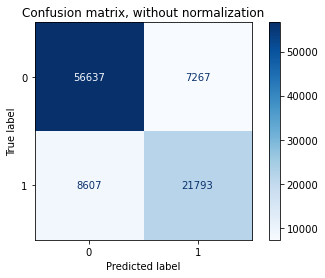

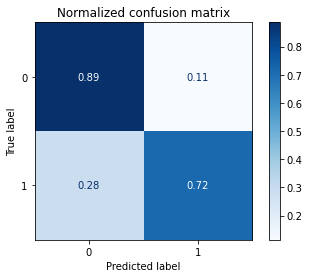

In [50]:
#Create confusion matrix for Logistic Model - All Variables
confusion_matrix(logModel, x_test, y_test, 'Confusion_Mat_LR_All.png', plt.cm.Blues)

Confusion matrix, without normalization
[[56522  7218]
 [ 9792 20772]]
Normalized confusion matrix
[[0.88675871 0.11324129]
 [0.32037691 0.67962309]]


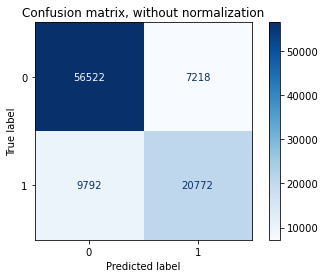

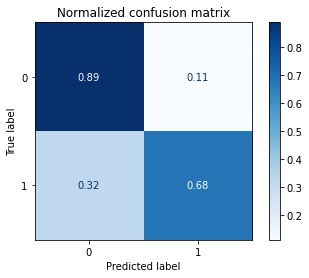

In [51]:
#Create confusion matrix for Logistic Model - Select Variables
confusion_matrix(logModel2, x2_test, y2_test, 'Confusion_Mat_LR_Select.png', plt.cm.Blues)

# Discriminant Analysis

### 1. Discriminant Analysis with All Variables

In [52]:
#import Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#Split data for training and testing. Again, 70% Training and 30% Testing.
da_x_train, da_x_test, da_y_train, da_y_test = train_test_split(x, y, test_size = 0.3)

#Create model obejct
daModel = LinearDiscriminantAnalysis()
#Fit model with training data
fit_modelDA = daModel.fit(da_x_train, da_y_train)

#Connect predictions to dataframe with Logistic Regression results
#Create dataframe of Discriminant Analysis prediction results
df = pd.DataFrame(daModel.predict(da_x_test), columns=['DA_All_Pred'], index = x_test.index.copy())
print(df)
#Merge with dataframe produced after the second DA Model
df_da = pd.merge(df_out2, df, how = 'left', left_index = True, right_index = True)
#Replace null values with 2 because that indicates training data.
df_da.fillna(value=2, inplace=True)
#Finally, add new columns with calculated DA linear equation
df_da['DA_All'] = ((daModel.coef_[0][0]*df_da['Band1'])+(daModel.coef_[0][1]*df_da['Band2'])+(daModel.coef_[0][2]*df_da['Band3'])+(daModel.coef_[0][3]*df_da['Band4'])+(daModel.coef_[0][4]*df_da['Band5'])+(daModel.coef_[0][5]*df_da['Band6'])+(daModel.coef_[0][6]*df_da['Band7'])+(daModel.coef_[0][7]*df_da['NDVI'])+(daModel.coef_[0][8]*df_da['SAVI'])+(daModel.coef_[0][9]*df_da['MSAVI'])+(daModel.coef_[0][10]*df_da['NDMI'])+(daModel.coef_[0][11]*df_da['TCBright'])+(daModel.coef_[0][12]*df_da['TCGreen'])+(daModel.coef_[0][13]*df_da['TCWet']+daModel.intercept_))

print (df_da)

        DA_All_Pred
329055          0.0
315199          1.0
416572          0.0
313617          0.0
147003          0.0
...             ...
322412          1.0
268183          0.0
17089           0.0
105296          1.0
265686          1.0

[94304 rows x 1 columns]
        Landcover  GM_Presence       Band1       Band2        Band3  \
602          43.0          0.0  303.164825  415.967316   789.300415   
603          43.0          0.0  338.623688  449.160767   738.687439   
604          43.0          0.0  299.536682  416.954041   733.375916   
605          41.0          0.0  332.190002  444.117798   854.510742   
606          41.0          0.0  523.816040  634.345642  1083.464844   
...           ...          ...         ...         ...          ...   
501084       43.0          0.0  176.760757  223.303848   522.896484   
501085       43.0          0.0  185.020050  227.481110   514.465515   
501086       41.0          0.0  193.221130  230.548569   507.148224   
501087       43.0       

### 2. Discriminant Analysis with Select Independent Variables

In [46]:
#The final model I am running is Discriminant Analysis with select variables
#Split data for training and testin
da_x2_train, da_x2_test, da_y2_train, da_y2_test = train_test_split(x2, y, test_size = 0.3)

#Create model object
daModel2 = LinearDiscriminantAnalysis()
#
fit_modelDA = daModel2.fit(da_x2_train, da_y2_train)

#Connect predictions to data frame produced with first LR model
df = pd.DataFrame(daModel2.predict(da_x2_test), columns=['DA_Select_Pred'], index = x_test.index.copy())
GM_Full_Result = pd.merge(df_da, df, how = 'left', left_index = True, right_index = True)
GM_Full_Result.fillna(value=2, inplace=True)

#Finally, add new columns with second calculated DA linear equation
GM_Full_Result['DA_Select'] = ((daModel2.coef_[0][0]*GM_Full_Result['NDVI'])+(daModel2.coef_[0][1]*GM_Full_Result['NDMI'])+(daModel2.coef_[0][2]*GM_Full_Result['TCGreen'])+(daModel2.coef_[0][3]*GM_Full_Result['TCWet']+daModel2.intercept_))

#Again, I exported this dataframe to a CSV to open it in R. 
GM_Full_Result.to_csv("C:\\Users\\Emily\\Documents\\Summer_2020\\Py_DataScience_and_MachineLearning\\original\\Gypsy_Moth\\Landsat8Imagery\\GM_Full_Result.csv")

Confusion matrix, without normalization
[[57144  6652]
 [ 9109 21399]]
Normalized confusion matrix
[[0.89573014 0.10426986]
 [0.29857742 0.70142258]]


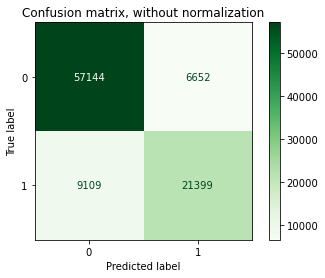

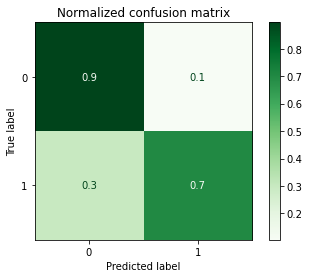

In [53]:
#Create confusion matrix for Logistic Regression - All Indpendent Variables
confusion_matrix(daModel, da_x_test, da_y_test, 'Confusion_Mat_DA_All.png', plt.cm.Greens)

Confusion matrix, without normalization
[[55904  7771]
 [ 8114 22515]]
Normalized confusion matrix
[[0.87795838 0.12204162]
 [0.26491234 0.73508766]]


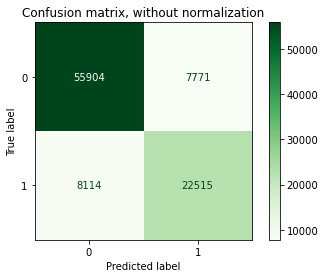

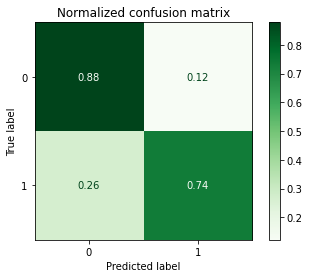

In [54]:
#Create confusion matrix for Logistic Regression - Select Indpendent Variables
confusion_matrix(daModel2, da_x2_test, da_y2_test, 'Confusion_Mat_Da_Select.png', plt.cm.Greens)

In [59]:
%%R
#I am back to using R in this cell because I am making another TOC Curv diagram.
##Open the CSV saved from the earlier portion of this code.
GM_Full_Result <- read.csv(file ="GM_Full_Result.csv", header=TRUE, dec=".", stringsAsFactors=FALSE)

In [60]:
%%R
##Create new numeric index variables from dataframe columns. I am using the calculated values from the coefficients/intercept for each model as the index.
LR_All <- (GM_Full_Result$LR_All)
LR_Select <- (GM_Full_Result$LR_Select)
DA_All <- (GM_Full_Result$DA_All)
DA_Select <- (GM_Full_Result$DA_Select)

##Create reference.boolean image for input into TOC
boolean <- (GM_Full_Result$GM_Presence)

In [61]:
%%R
## These lines create TOC objects. This creates 100 equal intervals. 
tocdLA <- TOC(LR_All, boolean, nthres=100, thres=NULL, P=NA, Q=NA,
              progress=FALSE, units=character(0))
tocdLS <- TOC(LR_Select, boolean, nthres=100, thres=NULL, P=NA, Q=NA,
              progress=FALSE, units=character(0))
tocdDA <- TOC(DA_All, boolean, nthres=100, thres=NULL, P=NA, Q=NA,
              progress=FALSE, units=character(0))
tocdDS <- TOC(DA_Select, boolean, nthres=100, thres=NULL, P=NA, Q=NA,
              progress=FALSE, units=character(0))

In [62]:
%%R
#Create a JPG file to export second TOC plot
png(file = "GM_Classification_TOC.jpg", width = 550, height = 480)

#Set the plot to a square
par(pty="s")
#Create plot object and axes
graphics::plot(1, type="l", main = "TOC Curve", lty="dashed",xlab= "Hits+False Alarms (Pixels)", ylab="Hits (Pixels)",lwd=2, col=rgb(128,100,162, maxColorValue=255), xlim=c(0, 314346),ylim=c(0, 101575), bty='L')

#PLot multiple lines to create multi-TOC plot
#minimum line
lines(c(0, 101575), c(0,101575), 
      lty="dotdash", lwd=2, col=rgb(50, 50,50, maxColorValue=255)) 
# maximum line
lines(c(212771, 314346), c(0,101575), 
      lty="dotdash", lwd=2, col=rgb(50,50,50, maxColorValue=255)) 

# hits+misses line
lines(c(0, 314346), c(101575, 101575), lwd=3, col=rgb(150,150,150, maxColorValue=255))

# uniform line
lines(c(0, 314346), c(0, 101575), lty="dotted", lwd=2, col=rgb(25,25,25, maxColorValue=255))

#TOC object lines
#Band1
lines(tocdLA@table$"Hits+FalseAlarms", tocdLA@table$Hits, lwd=2, col=rgb(255,0,0, maxColorValue=255))
#Band2
lines(tocdLS@table$"Hits+FalseAlarms", tocdLS@table$Hits, lty="dotted", lwd=2, col=rgb(255,170,0, maxColorValue=255))
#Band3
lines(tocdDA@table$"Hits+FalseAlarms", tocdDA@table$Hits, lwd=2, col=rgb(0,150,150, maxColorValue=255))
#Band4
lines(tocdDS@table$"Hits+FalseAlarms", tocdDS@table$Hits, lty="dotted", lwd=2, col=rgb(100,255,100, maxColorValue=255))

#Set not area for plot legend
par(xpd=NA)
#Set legend. Must define names, line color, and line patterns. 
legend("topright", inset=c(-0.15, 0.6), c("Hits+Misses", "Minimum", "Maximum", "Uniform", "LR All", "LR Select", "DA All", "DA Select"), 
       col = c(rgb(150,150,150, maxColorValue=255), rgb(50, 50,50, maxColorValue=255), rgb(50,50,50, maxColorValue=255), rgb(25,25,25, maxColorValue=255), rgb(255,0,0, maxColorValue=255), rgb(255,170,0, maxColorValue=255), rgb(0,150,150, maxColorValue=255), rgb(100,255,100, maxColorValue=255)),
       lty = c(1, 4, 4, 3, 1, 3, 1, 3), merge = TRUE, bty="n", lwd=c(2, 2, 2, 2, 2, 2, 2, 2))

#End image development
dev.off()

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Emily\\AppData\\Local\\Temp\\tmps0zmafco\\Rplots001.png'

png 
  2 


In [72]:
%%R
#Saving AUC values. I will use these to rank the bands by AUC value.
aucLA <- tocdLA@AUC
aucLS <- tocdLS@AUC
aucDA <- tocdDA@AUC
aucDS <- tocdDS@AUC

In [73]:
%%R
#Finally, I rank the AUC values.
#Creating a dataframe for the input variables and their AUC values so I can rank the AUC values
TOC_df <- data.frame("AUC" = c(aucLA, aucLS, aucDA, aucDS), "Name" = c("LR All","LR Select", "DA All", "DA Select")) 

#Create a new column
TOC_df$rank <- NA
#Order the AUC values
order.AUC <- order(TOC_df$AUC)
#Create a new dataframe which is order by AUC
TOC_df1 <- TOC_df[order.AUC,]
#create a new column called "rank"
TOC_df1$rank <- rank(TOC_df1$AUC)
#Display that new dataframe
TOC_df1

        AUC      Name rank
2 0.8849700 LR Select    1
4 0.8950207 DA Select    2
1 0.8960981    LR All    3
3 0.8976305    DA All    4


In [74]:
#Add new columns to larger dataframe
crosstab = GM_Full_Result[["LR_All_Pred", "LR_All", "LR_Select_Pred", "LR_Select", "DA_All_Pred", "DA_All", "DA_Select_Pred", "DA_Select"]].copy()

GM_Data = GM_Data.join(crosstab,how='outer')

ValueError: columns overlap but no suffix specified: Index(['LR_All_Pred', 'LR_All', 'LR_Select_Pred', 'LR_Select', 'DA_All_Pred',
       'DA_All', 'DA_Select_Pred', 'DA_Select'],
      dtype='object')

In [75]:
GM_Data.describe()

,Landcover,GM_Presence,Band1,Band2,Band3,Band4,Band5,Band6,Band7,Band8,...,LR_Select_Pred,LR_Select,DA_All_Pred,DA_All,DA_Select_Pred,DA_Select,Cross_LR_All,Cross_LR_Select,Cross_DA_All,Cross_DA_Select
count,501835.000000,501835.000000,501835.000000,501835.000000,501835.000000,501835.000000,501835.000000,501835.000000,501835.000000,501835.000000,...,314346.000000,314346.000000,314346.000000,314346.000000,314346.000000,314346.000000,0.0,0.0,0.0,0.0
mean,43.482059,0.216211,175.881851,201.398270,371.671875,293.975983,2026.632690,1319.778809,623.611633,201.775711,...,1.489041,-1.268092,1.489031,-1.374798,1.496345,-1.336189,NaN,NaN,NaN,NaN
std,29.861376,0.424317,145.578918,166.616653,295.134216,263.880615,1637.552734,1059.251343,529.300720,155.791107,...,0.819634,1.982914,0.819645,2.535594,0.810739,2.417379,NaN,NaN,NaN,NaN
min,-128.000000,0.000000,-233.728867,-127.737000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-7.516654,0.000000,-11.193649,0.000000,-14.904188,NaN,NaN,NaN,NaN
25%,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,-2.911904,1.000000,-3.520690,1.000000,-3.430641,NaN,NaN,NaN,NaN
50%,41.000000,0.000000,238.237900,266.409912,530.029541,314.089325,2689.169189,1825.136353,742.947205,322.000000,...,2.000000,-1.376436,2.000000,-1.974077,2.000000,-1.642371,NaN,NaN,NaN,NaN
75%,43.000000,0.000000,291.006927,329.760040,608.452667,490.350098,3378.854126,2149.973389,1039.509338,322.000000,...,2.000000,0.333747,2.000000,0.549282,2.000000,0.674708,NaN,NaN,NaN,NaN
max,95.000000,3.000000,2436.635498,2740.566162,3286.294922,3575.005371,6195.914062,4451.320801,3543.995850,386.000000,...,2.000000,6.548066,2.000000,6.810999,2.000000,6.588448,NaN,NaN,NaN,NaN


In [76]:
#Make new columns with for crosstab results. In this case, we're filling the columns with null values
GM_Data['Cross_LR_All'] = np.nan
GM_Data['Cross_LR_Select'] = np.nan
GM_Data['Cross_DA_All'] = np.nan
GM_Data['Cross_DA_Select'] = np.nan
print (GM_Data)

        Landcover  GM_Presence  Band1  Band2  Band3  Band4  Band5  Band6  \
0            43.0          3.0    0.0    0.0    0.0    0.0    0.0    0.0   
1            43.0          3.0    0.0    0.0    0.0    0.0    0.0    0.0   
2            43.0          3.0    0.0    0.0    0.0    0.0    0.0    0.0   
3            43.0          3.0    0.0    0.0    0.0    0.0    0.0    0.0   
4            43.0          3.0    0.0    0.0    0.0    0.0    0.0    0.0   
...           ...          ...    ...    ...    ...    ...    ...    ...   
501830     -128.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0   
501831     -128.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0   
501832     -128.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0   
501833     -128.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0   
501834     -128.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0   

        Band7  Band8  ...  LR_Select_Pred  LR_Select  DA_All_Pred  DA_All  \
0         

In [97]:
#Assign crosstab values for DA select
def crosstab(x, y):

    GM_Data.loc[((GM_Data.GM_Presence == 0) & (x == 0)), y] = 4 #Correct Rejection
    GM_Data.loc[((GM_Data.GM_Presence == 1) & (x == 1)), y] = 1 #Hit
    GM_Data.loc[((GM_Data.GM_Presence == 0) & (x == 1)), y] = 2 #FA
    GM_Data.loc[((GM_Data.GM_Presence == 1) & (x == 0)), y] = 3 #Miss
    GM_Data.loc[((GM_Data.GM_Presence == 0) & (x == 2)), y] = 5 #Training Data - Foliated
    GM_Data.loc[((GM_Data.GM_Presence == 1) & (x == 2)), y] = 6 #Training Data - Defoliated
    GM_Data.loc[((GM_Data.GM_Presence == 3) & (x == 0)), y] = 0 #No Data
    GM_Data.loc[((GM_Data.GM_Presence == 3) & (x == 1)), y] = 0 #No Data
    GM_Data.loc[((GM_Data.GM_Presence == 3) & (x == 2)), y] = 0 #No Data
    GM_Data.describe()

In [107]:
#Assign crosstab values for LR - All Model
crosstab(GM_Data.LR_All_Pred, 'Cross_LR_All')

In [108]:
#Assign crosstab values for LR - Select Model
crosstab(GM_Data.LR_Select_Pred, 'Cross_LR_Select')

In [109]:
#Assign crosstab values for DA - All Model
crosstab(GM_Data.DA_All_Pred, 'Cross_DA_All')

In [101]:
#Assign crosstab values for DA - Select Model
crosstab(GM_Data.DA_Select_Pred, 'Cross_DA_Select')

In [102]:
#Turn crostab column into an array and then to a raster image
def export_to_TIFF(x):
    Pred_array = GM_Data[[x]].to_numpy()
    Pred_array = Pred_array.astype('uint8')

    Pred_reshape = np.reshape(Pred_array, (835, 601))

    with rio.open("GM_masked.tif") as src:
        out_meta = src.meta 
        out_meta.update({"count": "1"})

    with rio.open(x+'.tif', 'w', **out_meta) as dst:
        dst.write(Pred_reshape, indexes=1)

In [103]:
#Create raster for LR - All crosstab
export_to_TIFF('Cross_LR_All')

In [104]:
#Create raster for LR - Select crosstab
export_to_TIFF('Cross_LR_Select')

In [105]:
#Create raster for DA - All crosstab
export_to_TIFF('Cross_DA_All')

In [106]:
#Create raster for DA - Select crosstab
export_to_TIFF('Cross_DA_Select')